In [1]:
cd ../related_post_gen/python

/home/fizmat/Desktop/related_post_gen/python


In [2]:
from subprocess import run, PIPE, STDOUT
from shutil import which
import sys
from glob import iglob
import pandas as pd
from io import StringIO
from tqdm.notebook import tqdm

In [3]:
def python(*args, **kwargs):
    result = run([sys.executable, *args], text=True, capture_output=True, **kwargs)
    if result.stderr:
        print(result.stderr)
    result.check_returncode()
    return result.stdout
print(python("--version"))

Python 3.11.5



In [4]:
def git(*args, **kwargs):
    result = run([which("git"), *args], text=True, capture_output=True, **kwargs)
    if result.returncode:
        print(result.stderr)
    result.check_returncode()
    return result.stdout
print(git("show", "-s"))

commit 5598a84ac492effe5e6dd7e5d3cfc6b054ceec2b
Author: Ivan <fizmat.r66@gmail.com>
Date:   Wed Sep 27 23:37:45 2023 +0400

    add a different (non-matrix) numpy solution



In [5]:
def k_input_columns(k):
    assert k in {5, 6}
    columns = ["counter", "import", "compile", "input", "process", "output"]
    if k == 5:
        return columns[:2] + columns[3:]
    return columns

In [6]:
TIME_COLUMNS = ["import", "input", "process", "output"]

In [7]:
FILES = ["related.py", "related_np.py", "related_numba.py"]

In [8]:
# from commit that added detiled times to target branch
COMMITS = "0ca6f7eeb7329223976e857036786dbabdfa3898..numba2"

In [9]:
N = 20

In [10]:
def profile_file(f, n=N):
    print(f)
    # warm-up
    print(python(f))
    print(python(f, env={"DETAILED_PYTHON_PERF": "1"}))
    # measure
    buf = "\n".join(python(f, env={"DETAILED_PYTHON_PERF": "1"}).strip() 
                    for _ in tqdm(range(n)))
    record = pd.read_csv(StringIO(buf), sep="\t", header=None)
    record.columns = k_input_columns(len(record.columns))
    record["total"] = record.iloc[:, 1:].sum(axis=1)
    record.insert(0, "impl", f)
    return record

In [11]:
def profile_file_history(f, commits=COMMITS, n=N):
    data = []
    for i, h in enumerate(git("rev-list", "--reverse", commits, "--", f).splitlines()):
        git("checkout", h)
        subj = git("show", "-s", "--format=%s").strip()
        subj = f"{i:02}: {subj:.18}…"
        print(subj)
        record = profile_file(f, n)
        record.insert(1, "commit", subj)
        data.append(record)
    return pd.concat(data)


In [12]:
times = pd.concat(profile_file_history(f) for f in FILES) 

00: minor pythonizatio…
related.py
Processing time (w/o IO): 1.551s

perf_counter	0.005284433	0.006572604	1.539945248	0.148419525
process_time	0.005272123	0.006544214	1.538585545	0.1413516



  0%|          | 0/20 [00:00<?, ?it/s]

01: use ujson for IO…
related.py
Processing time (w/o IO): 1.523s

perf_counter	0.003025552	0.007841214	1.561321831	0.03441346
process_time	0.003018682	0.007813544	1.559910368	0.027663725



  0%|          | 0/20 [00:00<?, ?it/s]

02: use flat list appr…
related.py
Processing time (w/o IO): 1.136s

perf_counter	0.002804131	0.007682245	1.204290234	0.034466671
process_time	0.002795871	0.007654245	1.203314578	0.027381775



  0%|          | 0/20 [00:00<?, ?it/s]

03: replace ujson with…
related.py
Processing time (w/o IO): 1.129s

perf_counter	0.015426359	0.005343253	1.133969574	0.018453541
process_time	0.015382898	0.005326533	1.132924979	0.011363798



  0%|          | 0/20 [00:00<?, ?it/s]

00: use ujson for IO…
related_np.py
Processing time (w/o IO): 0.653s

perf_counter	0.061610295	0.009886406	0.656682668	0.034088621
process_time	0.622407363	0.118455	0.807114923	0.026926675



  0%|          | 0/20 [00:00<?, ?it/s]

01: np: use python set…
related_np.py
Processing time (w/o IO): 0.625s

perf_counter	0.061636986	0.009893016	0.629317703	0.027522876
process_time	0.621788512	0.118567832	0.779425431	0.027485715



  0%|          | 0/20 [00:00<?, ?it/s]

02: np: use smaller ma…
related_np.py
Processing time (w/o IO): 0.595s

perf_counter	0.061549825	0.009845556	0.605374269	0.026759716
process_time	0.621611612	0.118010742	0.755705321	0.026727475



  0%|          | 0/20 [00:00<?, ?it/s]

03: np: use dict of ta…
related_np.py
Processing time (w/o IO): 0.571s

perf_counter	0.062131496	0.010054276	0.575973112	0.027515816
process_time	0.627407754	0.1205166	0.718752115	0.027467716



  0%|          | 0/20 [00:00<?, ?it/s]

04: np: use scipy spar…
related_np.py
Processing time (w/o IO): 0.285s

perf_counter	0.093914124	0.007600455	0.292759238	0.027288386
process_time	0.912111261	0.007537845	0.292063242	0.027254655



  0%|          | 0/20 [00:00<?, ?it/s]

05: np: sort top5 rela…
related_np.py
Processing time (w/o IO): 0.243s

perf_counter	0.094020835	0.007628824	0.240350129	0.028177056
process_time	0.913689455	0.007581634	0.239960563	0.027727866



  0%|          | 0/20 [00:00<?, ?it/s]

06: replace ujson with…
related_np.py
Processing time (w/o IO): 0.240s

perf_counter	0.096559286	0.005319173	0.237217266	0.010981827
process_time	0.915258895	0.005309613	0.236880822	0.010969826



  0%|          | 0/20 [00:00<?, ?it/s]

00: add a different (n…
related_numba.py
Processing time (w/o IO): 1.478s

perf_counter	0.065425787	4.49e-06	0.006865214	1.456414621	0.011297046
process_time	0.686597029	3.068e-05	0.082302868	1.577867855	0.011282397



  0%|          | 0/20 [00:00<?, ?it/s]

01: accelerate summing…
related_numba.py
Processing time (w/o IO): 161.4ms

perf_counter	0.179631713	0.331926942	0.005379183	0.136695079	0.011063266
process_time	0.996877176	0.326292559	0.005363503	0.136533996	0.011049377



  0%|          | 0/20 [00:00<?, ?it/s]

02: move listing relat…
related_numba.py
Processing time (w/o IO): 129.3ms

perf_counter	0.183364196	0.569666698	0.005645264	0.124922442	0.01755101
process_time	1.002022108	0.565148455	0.005633423	0.124783669	0.011350766



  0%|          | 0/20 [00:00<?, ?it/s]

03: find top 5 posts i…
related_numba.py
Processing time (w/o IO): 75.6ms

perf_counter	0.180205654	0.789658585	0.005436423	0.074430493	0.011170937
process_time	0.999813893	0.781476524	0.005422393	0.074352162	0.011156996



  0%|          | 0/20 [00:00<?, ?it/s]

04: precompute tag arr…
related_numba.py
Processing time (w/o IO): 74.2ms

perf_counter	0.180259204	0.79667798	0.005425793	0.074467333	0.011258886
process_time	0.998974661	0.789376377	0.005415843	0.074386601	0.011247026



  0%|          | 0/20 [00:00<?, ?it/s]

05: move tag array loo…
related_numba.py
Processing time (w/o IO): 109.3ms

perf_counter	0.179652724	1.013128754	0.005395873	0.108792772	0.018397541
process_time	0.998861101	1.003733766	0.005380893	0.10863773	0.011517837



  0%|          | 0/20 [00:00<?, ?it/s]

06: move the outer loo…
related_numba.py
Processing time (w/o IO): 68.3ms

perf_counter	0.179799973	1.140585958	0.030317168	0.067743879	0.011342556
process_time	0.997413571	1.130732639	0.030236177	0.067679428	0.011328776



  0%|          | 0/20 [00:00<?, ?it/s]

07: replace post-to-ta…
related_numba.py
Processing time (w/o IO): 60.5ms

perf_counter	0.181535355	0.93625475	0.005443923	0.060706745	0.01836817
process_time	1.000068492	0.928963407	0.005432433	0.060654634	0.011255286



  0%|          | 0/20 [00:00<?, ?it/s]

08: parallelize outer …
related_numba.py
Processing time (w/o IO): 26.2ms

perf_counter	0.180709794	1.449526076	0.005286873	0.027891076	0.018824271
process_time	0.997495271	1.4409215	0.006195973	0.125888157	0.011916127



  0%|          | 0/20 [00:00<?, ?it/s]

09: replace tag-to-pos…
related_numba.py
Processing time (w/o IO): 55.9ms

perf_counter	0.179749634	1.095344282	0.005621123	0.055848582	0.018461191
process_time	0.999324941	1.089524211	0.006309644	0.190541369	0.011394546



  0%|          | 0/20 [00:00<?, ?it/s]

In [13]:
if "compile" in times:
    times.insert(4, "compile", times.pop("compile").fillna(0))

In [14]:
from uncertainties import ufloat

def pretty_stddev(df: pd.DataFrame):
    return (1000 * df).apply(lambda c: f"{ufloat(c.mean(), c.std()):.2ufP}")

table = times.groupby(["impl", "counter", "commit"]).apply(pretty_stddev)
table

import  \
impl             counter      commit                                 
related.py       perf_counter 00: minor pythonizatio…  5.238±0.031   
                              01: use ujson for IO…    3.016±0.036   
                              02: use flat list appr…  2.797±0.038   
                              03: replace ujson with…   15.35±0.17   
                 process_time 00: minor pythonizatio…  5.230±0.030   
                              01: use ujson for IO…    3.009±0.034   
                              02: use flat list appr…  2.790±0.036   
                              03: replace ujson with…   15.32±0.16   
related_np.py    perf_counter 00: use ujson for IO…     60.91±0.21   
                              01: np: use python set…   61.37±0.65   
                              02: np: use smaller ma…   61.06±0.31   
                              03: np: use dict of ta…   61.23±0.28   
                              04: np: use scipy spar…   93.65±0.25   
                              05: np: sort top5 rela…   93.86±0.36   
                              06: replace ujson with…   96.62±0.37   
                 process_time 00: use ujson for IO…      614.2±4.2   
                              01: np: use python set…    619.4±6.8   
                              02: np: use smaller ma…    616.5±3.1   
                              03: np: use dict of ta…    618.3±2.7   
                              04: np: use scipy spar…  912.66±0.42   
                              05: np: sort top5 rela…  913.01±0.79   
                              06: replace ujson with…  915.64±0.85   
related_numba.py perf_counter 00: add a different (n…   64.91±0.33   
                              01: accelerate summing…    179.9±1.2   
                              02: move listing relat…    179.9±1.3   
                              03: find top 5 posts i…  179.69±0.77   
                              04: precompute tag arr…  180.04±0.98   
                              05: move tag array loo…    179.9±1.4   
                              06: move the outer loo…    180.6±1.0   
                              07: replace post-to-ta…  180.11±0.84   
                              08: parallelize outer …    180.2±1.0   
                              09: replace tag-to-pos…  180.69±0.83   
                 process_time 00: add a different (n…    680.9±3.3   
                              01: accelerate summing…    998.7±1.8   
                              02: move listing relat…    999.0±1.3   
                              03: find top 5 posts i…  998.73±0.93   
                              04: precompute tag arr…    999.2±1.1   
                              05: move tag array loo…    998.8±1.8   
                              06: move the outer loo…    999.7±1.3   
                              07: replace post-to-ta…    999.0±1.3   
                              08: parallelize outer …    999.5±1.2   
                              09: replace tag-to-pos…    999.7±1.3   

                                                               compile  \
impl             counter      commit                                     
related.py       perf_counter 00: minor pythonizatio…           0.00±0   
                              01: use ujson for IO…             0.00±0   
                              02: use flat list appr…           0.00±0   
                              03: replace ujson with…           0.00±0   
                 process_time 00: minor pythonizatio…           0.00±0   
                              01: use ujson for IO…             0.00±0   
                              02: use flat list appr…           0.00±0   
                              03: replace ujson with…           0.00±0   
related_np.py    perf_counter 00: use ujson for IO…             0.00±0   
                              01: np: use python set…           0.00±0   
                              02: np: use smaller ma…           0.00±0   
                 

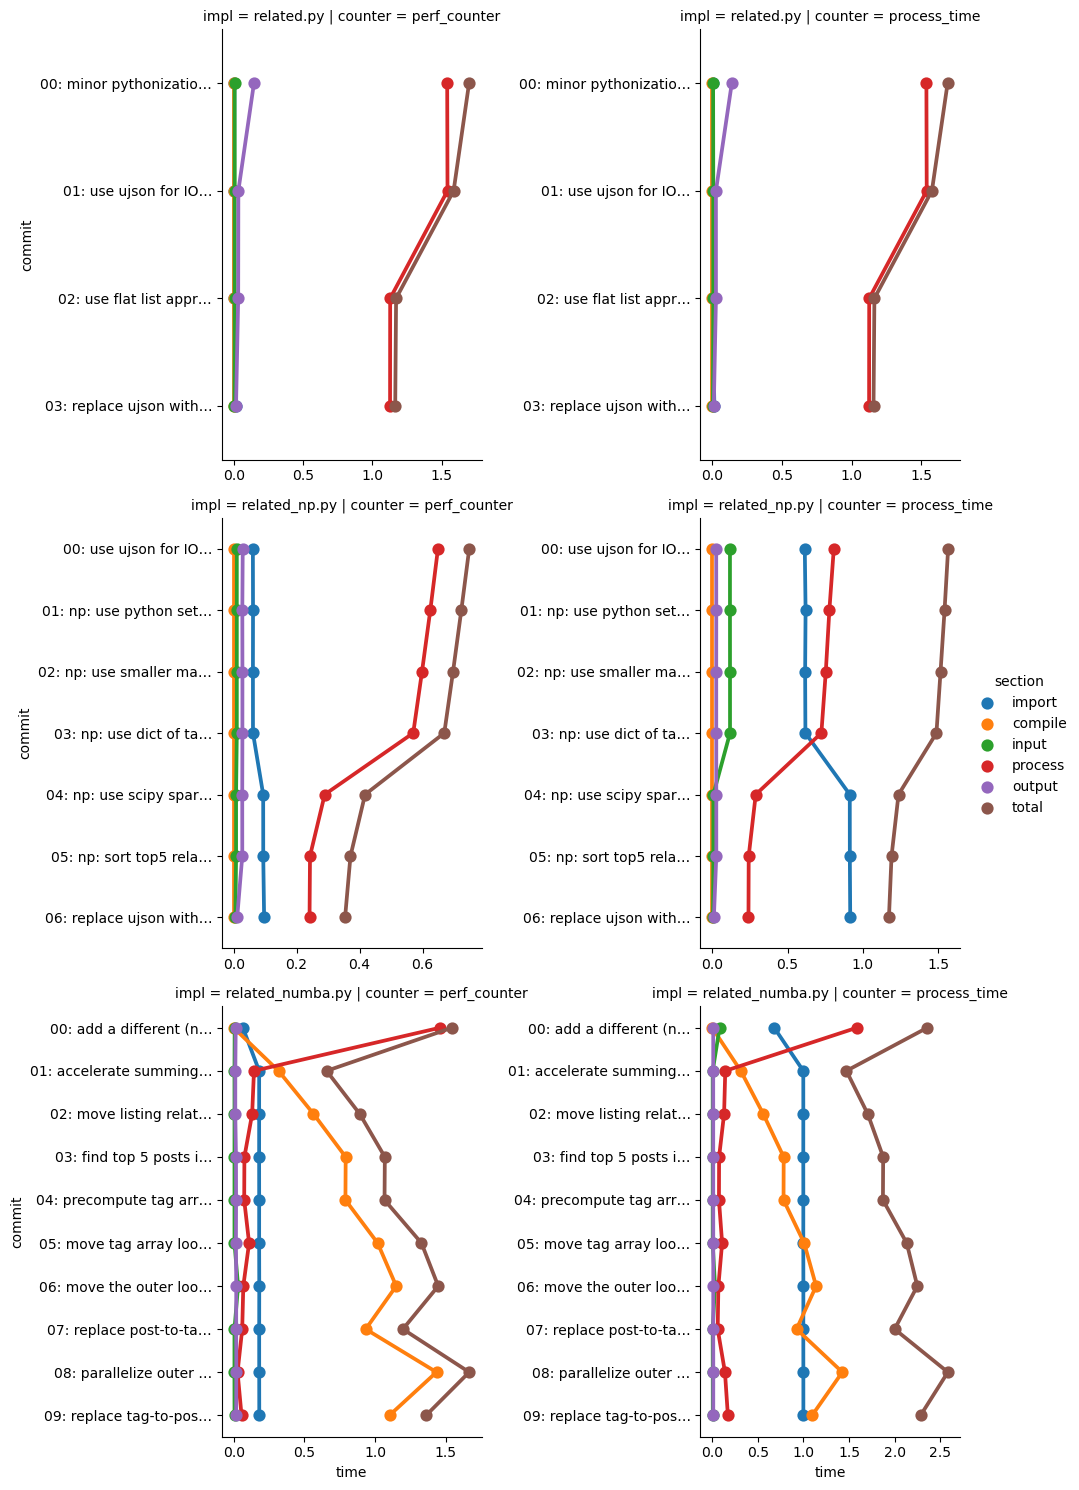

In [15]:
import seaborn as sns
from matplotlib import pyplot as plt
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

tidy = times.melt(id_vars=["impl", "commit", "counter"],
                  var_name="section", value_name="time")
grid = sns.catplot(tidy, hue="section", y="commit", x="time",
                   row="impl", col="counter", kind="point",
                  sharex=False, sharey=False)


In [16]:
def stddev(df: pd.DataFrame):
    return (1000 * df).apply(lambda c: ufloat(c.mean(), c.std()))

final_table = times.groupby(["counter", "impl", "commit"]).apply(stddev) \
    .groupby(level=[0,1]).last() \
    .reset_index() \
    .sort_values(["counter", "process"]) \
    .set_index(["counter", "impl"]) \
    .map(lambda v: f"{v:.2ufP}")
final_table

import     compile        input  \
counter      impl                                                     
perf_counter related_numba.py  180.69±0.83  1102.5±8.6    5.62±0.10   
             related_np.py      96.62±0.37      0.00±0  5.313±0.049   
             related.py         15.35±0.17      0.00±0  5.256±0.079   
process_time related_numba.py    999.7±1.3  1096.7±8.1    6.55±0.24   
             related_np.py     915.64±0.85      0.00±0  5.291±0.033   
             related.py         15.32±0.16      0.00±0  5.237±0.072   

                                  process        output       total  
counter      impl                                                    
perf_counter related_numba.py    55.2±1.5      17.3±2.8  1361.4±9.2  
             related_np.py      241.0±4.2    10.99±0.16   353.9±4.2  
             related.py        1126.8±6.6      16.7±3.0  1164.2±7.5  
process_time related_numba.py      172±11    11.59±0.14     2286±12  
             related_np.py      240.6±4.2  10.948±0.070  1172.5±4.6  
             related.py        1125.9±6.5  11.329±0.096  1157.8±6.7

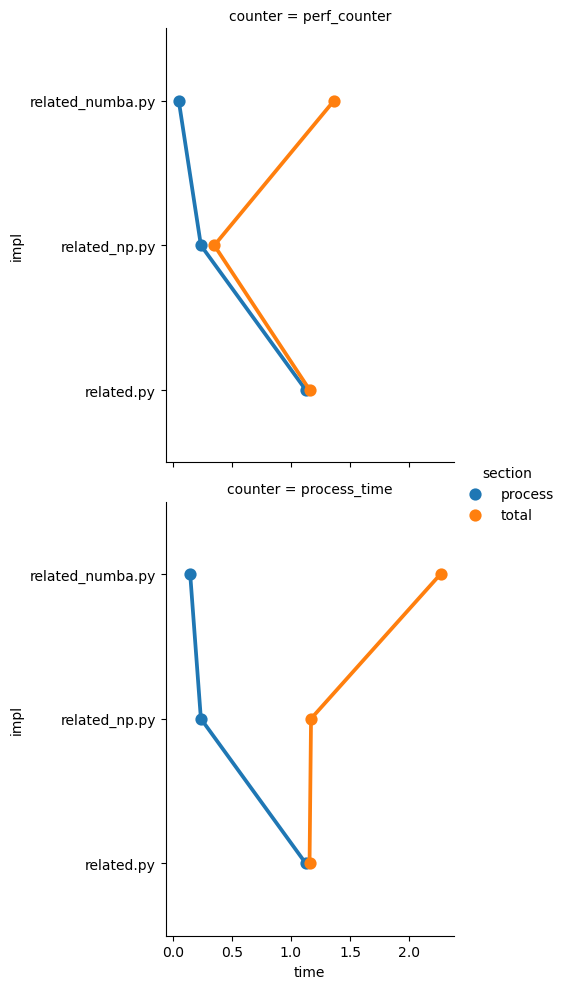

In [17]:
order = final_table.loc["perf_counter"].index
finals = times[["impl", "counter", "process", "total"]] \
    .groupby(["impl", "counter"]).last().reset_index() \
    .melt(id_vars=["impl", "counter"], var_name="section", value_name="time")
sns.catplot(finals, hue="section", y="impl", x="time",
            row="counter", kind="point",
            order=order)